In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import reuters

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
(X_train, y_train),(X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
# 데이터 확인
category = np.max(y_train) + 1
print(f'{category} 카테고리')
print(f'{len(X_train)} 학습용 뉴스기사')
print(f'{len(X_test)} 테스트용 뉴스기사')

46 카테고리
8982 학습용 뉴스기사
2246 테스트용 뉴스기사


In [ ]:
# 첫번쨰 뉴스 기사 확인
print(X_train[0])
print(y_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [ ]:
# 뉴스 기사의 길이
print(f'뉴스 기사의 최대 길이 : {max(len(i) for i in X_train)}')
print(f'뉴스 기사의 평균 길이 : {sum(len(i) for i in X_train)/len(X_train)}')

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


In [ ]:
index_to_word = {}
for key, value in reuters.get_word_index().items():
    index_to_word[value] = key
len(index_to_word)

30979

In [ ]:
# 첫번쨰 뉴스 기사 복원
print(' '.join([index_to_word[s] for s in X_train[0]]))

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


In [ ]:
unique_elements, counts_elements = \
    np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
label_cnt=dict(zip(unique_elements, counts_elements))
print(label_cnt)

각 레이블에 대한 빈도수:
{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


## LSTM으로 로이터 뉴스 분류
- 모든 단어가 아닌 빈도수 1000 까지
- 모든 문장이 아니라 100 단어까지

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# 등장빈도 1000번쨰까지 단어들만 사용
(X_train, y_train),(X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
# 모델 입력 기사의 길이를 100으로 맞춤
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# one-hot-incoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [ ]:
# LSTM 모델
model = Sequential([
                    Embedding(1000, 120),
                    LSTM(120),
                    Dense(46,activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5566      
Total params: 241,246
Trainable params: 241,246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_best_model.h5', 
                    verbose=1, save_best_only=True)

In [ ]:
# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=50,
                    validation_split = 0.2, verbose=2,
                    callbacks=[mc,es])

Epoch 1/50
72/72 - 3s - loss: 2.6277 - accuracy: 0.3417 - val_loss: 2.4051 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from inf to 2.40508, saving model to model/reuter_best_model.h5
Epoch 2/50
72/72 - 1s - loss: 2.1727 - accuracy: 0.4445 - val_loss: 2.0406 - val_accuracy: 0.4903

Epoch 00002: val_loss improved from 2.40508 to 2.04056, saving model to model/reuter_best_model.h5
Epoch 3/50
72/72 - 1s - loss: 1.9754 - accuracy: 0.4820 - val_loss: 1.9203 - val_accuracy: 0.4213

Epoch 00003: val_loss improved from 2.04056 to 1.92025, saving model to model/reuter_best_model.h5
Epoch 4/50
72/72 - 1s - loss: 1.7896 - accuracy: 0.5356 - val_loss: 1.7304 - val_accuracy: 0.5537

Epoch 00004: val_loss improved from 1.92025 to 1.73036, saving model to model/reuter_best_model.h5
Epoch 5/50
72/72 - 1s - loss: 1.6873 - accuracy: 0.5648 - val_loss: 1.6839 - val_accuracy: 0.5659

Epoch 00005: val_loss improved from 1.73036 to 1.68389, saving model to model/reuter_best_model.h5
Epoch 6/50
72/

In [ ]:
# Best Model 선택
del model
model = load_model('model/reuter_best_model.h5')

In [ ]:
print(f"\n 테스트 정확도: {model.evaluate(X_test, Y_test, verbose=2)}")

71/71 - 1s - loss: 1.2228 - accuracy: 0.7039

 테스트 정확도: [1.2228258848190308, 0.7039180994033813]


In [ ]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

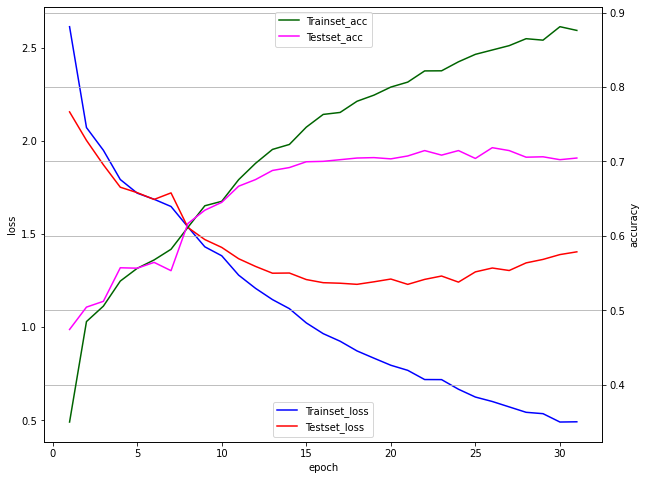

In [ ]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()